# Knowledge graph data integration

Overlay multi-omic data in the knwoledge network (Figure 4)

# Setup

## Module import

In [1]:
# basic 
import os, io, glob, re, time, json, math

from datetime import datetime
from collections import defaultdict
from pathlib import Path
from contextlib import redirect_stdout, redirect_stderr

# data
import pandas as pd
import numpy as np
from pandas import option_context

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# networks & cytoscape
import py4cytoscape as p4c
import networkx as nx

# notebook niceties
from IPython.display import display, Markdown, HTML

## Settings and basic functions

In [2]:
today = datetime.today().strftime('%Y-%m-%d'); print(today)
fake_logger = io.StringIO()

2024-12-10


In [3]:
def swatches(colors, sep=' ', width=6):
    display(Markdown(sep.join(
        f'<span style="font-family: monospace">{color} <span style="color: {color}">{chr(9608)*width}</span></span>'
        for color in colors
    )))
    
def display_df(df, caption=None, vmax=1, vmin=-1):
    with option_context('display.max_colwidth', 3):


        s = df.style.background_gradient(
            cmap='vlag', vmax=vmax, vmin=vmin, axis=1).format(na_rep='-', precision=3)
        s.format_index(lambda v: v[:5], axis=1)
        s.map(lambda x: 'background: #E5E5E5' if pd.isnull(x) else '')
        
        if caption: 
            s.set_caption(caption)
        
        display(s)

    return s

## Directory paths

In [4]:
base_dir = Path("..")
input_dir = base_dir / "input" 
output_dir = base_dir / "output" 
fig_dir = output_dir / "figures"

# Organise data

## Node annotations

In [5]:
all_days = [
    'D08',
    'D14',
    'D28',
    'H01',
    'H07',
    'H08',
    'H14',
    'H28',
    'HD08',
    'HD14',
    'HD28',
    'W01',
    'W07',
    'W28'
]

In [6]:
node_df = pd.read_csv(input_dir / "node-annotations.tsv", sep="\t")
node_df["mapman_bin"] = node_df["mapman_bin"].apply(lambda x: x.split(" | ") if not pd.isna(x) else np.nan)
node_df.tail()

,biochem_net_name,display_name,pathway,protein_name,short_name,name,group,mapman_bin,description
94,VdnPW3_37011,CLPB4,HSP,VdnPW3_37011,CLPB4,pr.CLPB4,proteomics,"[20.2.1 stress.abiotic.heat, 20.2 stress.abiot...",Chaperone protein clpB 2
95,VdnPW4_15664,ACA11,Ca,VdnPW4_15664,ACA11,pr.ACA11,proteomics,"[34.21 transport.calcium, 30.3 signalling.calc...",Calcium-transporting ATPase 1
96,VdnPW4_18801,KARI,Amino,VdnPW4_18801,F14P22.200,pr.F14P22.200,proteomics,[13.1.4.1.2 amino acid metabolism.synthesis.br...,Ketol-acid reductoisomerase
97,VdnPW5_1541,LHCA3,PS,VdnPW5_1541,LHCA3,pr.LHCA3,proteomics,"[1.1.2.1 PS.lightreaction.photosystem I.LHC-I,...","Chlorophyll a-b binding protein 8, chloroplastic"
98,WATER.CONSUMPTION,Water consumption,NaN,NaN,NaN,ph.WATER.CONSUMPTION,phenomics,NaN,Absolute weight trait based on weighing of the...


## Log fcs (all nodes except phenomics)

In [7]:
def mapper(x):
    try: return node_df.set_index("biochem_net_name").loc[x]["name"] 
    except KeyError: print(x)

In [8]:
raw_logfc_df = pd.read_csv(input_dir / "logFCs.tsv", sep="\t", na_values=['-'])
raw_logfc_df.head()

,Variable,D08.logFC,D14.logFC,D28.logFC,H01.logFC,H07.logFC,H08.logFC,H14.logFC,H28.logFC,HD08.logFC,...,H07.pVal,H08.pVal,H14.pVal,H28.pVal,HD08.pVal,HD14.pVal,HD28.pVal,W01.pVal,W07.pVal,W28.pVal
0,12-OH-JA,-0.270227,-0.750779,NaN,1.407850,-0.057980,-1.048938,0.250858,NaN,-1.375543,...,1.000,0.00767,0.3480,NaN,0.001,0.082,NaN,0.187,1.000,NaN
1,13-LOX,0.538457,2.143337,NaN,0.022999,-0.339275,0.484631,3.738998,NaN,-0.412145,...,0.585,0.26900,0.0112,NaN,0.154,0.164,NaN,0.022,0.046,NaN
2,"9,10-dhJA",-0.429406,-0.190769,NaN,0.745790,-0.273136,0.604954,0.010288,NaN,-0.371449,...,0.472,0.08830,0.9810,NaN,0.801,0.017,NaN,0.111,0.284,NaN
3,ABA,-0.187646,0.945340,NaN,0.336843,-0.736415,-1.540812,-0.480126,NaN,-0.528245,...,0.119,0.01840,0.0326,NaN,0.534,0.859,NaN,0.025,0.042,NaN
4,ACO2,-0.043252,1.626726,NaN,-0.741639,-1.254482,1.166674,1.614193,NaN,-1.093032,...,0.229,0.03620,0.1200,NaN,0.255,0.144,NaN,0.208,0.616,NaN


In [9]:
raw_logfc_df["name"] = raw_logfc_df["Variable"].apply(mapper)

In [10]:
raw_logfc_df = raw_logfc_df[~raw_logfc_df["name"].isna()]

In [11]:
logFC_cols = [c for c in raw_logfc_df.columns if re.match(r"^.*\.logFC", c)]; logFC_cols

['D08.logFC',
 'D14.logFC',
 'D28.logFC',
 'H01.logFC',
 'H07.logFC',
 'H08.logFC',
 'H14.logFC',
 'H28.logFC',
 'HD08.logFC',
 'HD14.logFC',
 'HD28.logFC',
 'W01.logFC',
 'W07.logFC',
 'W28.logFC']

In [12]:
# merge table 
node_df = node_df.set_index("name").join(raw_logfc_df.set_index("name")[logFC_cols], on="name", how="outer")

## Phenomics

In [13]:
# Supp. Table 5.xlsx
df_phenomics = pd.read_csv(input_dir / "data_phenomics.txt", sep="\t")
df_phenomics[["treatment", "day", "rep"]] = df_phenomics["SampleID"].str.split("_", expand=True)
del df_phenomics["SampleID"]
del df_phenomics["rep"]
display(df_phenomics.head())
print(df_phenomics.shape)

,TOP.AREA,COMPACTNESS,Fv.Fm,qL,deltaT,WATER.CONSUMPTION,Num_Tubers,Total_Tubers_Weight,FW_SH_Total,DW_SH_Total,treatment,day
0,96416.320617,0.675144,0.714843,0.830648,1.119381,77.0,NaN,NaN,NaN,NaN,C,S1
1,92754.842046,0.710871,0.713718,0.795229,0.883825,78.0,NaN,NaN,NaN,NaN,C,S1
2,77862.689354,0.675588,0.717358,0.792627,1.365189,34.0,NaN,NaN,NaN,NaN,C,S1
3,101872.301537,0.712169,0.713340,0.841509,1.245829,68.0,NaN,NaN,NaN,NaN,C,S1
4,90507.247872,0.716727,0.706543,0.846210,1.355232,77.0,NaN,NaN,NaN,NaN,C,S1


(364, 12)


In [14]:
df_phenomics = df_phenomics.groupby(by=["treatment", "day"]).mean()
df_phenomics.head()

TOP.AREA  COMPACTNESS     Fv.Fm        qL    deltaT  \
treatment day                                                             
C         P28            NaN          NaN       NaN       NaN       NaN   
          S1    94720.535034     0.696457  0.712036  0.824933  1.167246   
          S14  168017.795272     0.730752  0.690918  0.858861  1.701229   
          S15  169275.325866     0.726081  0.684816  0.848090  1.587220   
          S21  169634.508817     0.724695  0.673477  0.765046  1.924645   

               WATER.CONSUMPTION  Num_Tubers  Total_Tubers_Weight  \
treatment day                                                       
C         P28                NaN        12.5             124.9775   
          S1           71.333333         NaN                  NaN   
          S14         133.500000         NaN                  NaN   
          S15          83.500000         NaN                  NaN   
          S21         118.000000         NaN                  NaN   

               FW_SH_Total  DW_SH_Total  
treatment day                            
C         P28          NaN          NaN  
          S1      71.21475      3.58350  
          S14    116.34675      7.61575  
          S15    121.57775      8.25475  
          S21    119.80075      8.75225

In [15]:
relative_changes = {}
for x in all_days:
    treatment, day = re.match(r"([A-Z]*)(\d*)", x).groups()
    
    if day == '28':
        t = df_phenomics.loc[(treatment, f"P{day.lstrip('0')}")]        
        c = df_phenomics.loc[("C", f"P{day.lstrip('0')}")]
    else:
        t = df_phenomics.loc[(treatment, f"S{day.lstrip('0')}")]
        c = df_phenomics.loc[("C", f"S{day.lstrip('0')}")]
    rc = (t/c -1)
    rc.index = [f"ph.{x}" for x in rc.index]
    relative_changes[x] = rc

In [16]:
phenomics_RC = pd.DataFrame.from_records(relative_changes)
_ = display_df(phenomics_RC, vmax=0.20, vmin=-0.20)

,D08,D14,D28,H01,H07,H08,H14,H28,HD08,HD14,HD28,W01,W07,W28
ph.TOP.AREA,-0.023,-0.174,-,-0.003,-0.197,-0.201,-0.242,-,-0.252,-0.351,-,-0.102,-0.531,-
ph.COMPACTNESS,-0.024,-0.053,-,0.030,0.093,0.087,0.040,-,0.091,0.034,-,-0.103,-0.181,-
ph.Fv.Fm,-0.002,-0.012,-,0.007,0.023,0.023,-0.020,-,0.011,-0.038,-,-0.005,-0.211,-
ph.qL,0.002,0.041,-,-0.053,-0.155,-0.152,-0.213,-,-0.091,-0.137,-,-0.003,-0.013,-
ph.deltaT,-0.066,0.337,-,-0.510,-0.516,-0.269,-0.221,-,-0.065,0.023,-,0.430,1.374,-
ph.WATER.CONSUMPTION,-0.031,-0.471,-,1.002,0.654,0.684,0.422,-,0.334,-0.227,-,0.180,-0.679,-
ph.Num_Tubers,-,-,0.260,-,-,-,-,0.320,-,-,0.160,-,-,-0.820
ph.Total_Tubers_Weight,-,-,-0.046,-,-,-,-,-0.483,-,-,-0.484,-,-,-0.974
ph.FW_SH_Total,-0.088,-0.123,-,0.044,-0.145,-0.136,-0.006,-,-0.156,-0.186,-,-0.087,-0.369,-
ph.DW_SH_Total,-0.117,-0.120,-,0.072,-0.122,-0.268,0.227,-,-0.125,-0.105,-,-0.066,-0.240,-


In [17]:
# Add phenomics rc to main table
for group, group_df in node_df.groupby("group"):
    if group == "phenomics":
        for idx, g in group_df.iterrows():
            print(idx)           
            node_df.loc[idx, [f"{day}.percent_relative_change" for day in all_days]] = phenomics_RC.loc[g.name].values * 100

ph.COMPACTNESS
ph.DW_SH_Total
ph.FW_SH_Total
ph.Fv.Fm
ph.Num_Tubers
ph.TOP.AREA
ph.Total_Tubers_Weight
ph.WATER.CONSUMPTION
ph.deltaT
ph.qL


In [18]:
RC_cols = [f"{day}.percent_relative_change" for day in all_days]; RC_cols

['D08.percent_relative_change',
 'D14.percent_relative_change',
 'D28.percent_relative_change',
 'H01.percent_relative_change',
 'H07.percent_relative_change',
 'H08.percent_relative_change',
 'H14.percent_relative_change',
 'H28.percent_relative_change',
 'HD08.percent_relative_change',
 'HD14.percent_relative_change',
 'HD28.percent_relative_change',
 'W01.percent_relative_change',
 'W07.percent_relative_change',
 'W28.percent_relative_change']

## Parts of tables to LaTex

In [19]:
s = display_df(phenomics_RC.loc[["ph.Num_Tubers", "ph.Total_Tubers_Weight"]][["D28", "H28", "HD28", "W28"]])
s.to_latex(output_dir / "phenomics_28_rc.tex", convert_css=True)

,D28,H28,HD28,W28
ph.Num_Tubers,0.260,0.320,0.160,-0.820
ph.Total_Tubers_Weight,-0.046,-0.483,-0.484,-0.974


In [20]:
s = display_df(node_df[node_df["group"]=="metabolomics"][["D28.logFC", "H28.logFC", "HD28.logFC", "W28.logFC"]].dropna(how="all"),
          vmax=1, vmin=-1)
s.to_latex(output_dir / "metabolomics_28_logfc.tex", convert_css=True)

,D28.l,H28.l,HD28.,W28.l
name,,,,
me.Ala,-0.137,-0.731,-0.437,0.919
me.Arg,-0.291,-0.710,-0.262,1.588
me.Asn,-0.124,-0.508,-0.187,2.802
me.Asp,-0.107,-0.038,0.164,1.230
me.Fructose,0.185,-0.362,0.497,0.708
me.Gln,-0.056,-0.562,-0.098,2.611
me.Glu,-0.225,-0.404,-0.299,0.091
me.Glukose,-0.520,0.886,1.026,-0.363
me.Gly,-0.300,-0.846,-0.568,1.045


## Cytoscape

### Add colour scale column to node table

In Cytoscape, can only use one column to define a colour mapping. Thus need to create a combined column to map log fold change (FC) and relative change (RC) to  node fill colour. The colum is created by combining FC with RC, adding an buffer to the RC, so the colour scale is (simplified):

    logFC_min ~ 0 ~ logFC_max ~ buffer ~ rc_min+buffer ~ 0+buffer ~ rc_max+buffer


In [21]:
logfc_min = raw_logfc_df[logFC_cols].min().min()
logfc_max = raw_logfc_df[logFC_cols].max().max()
logfc_min, logfc_max

(-3.82922465300375, 7.68224512114979)

In [22]:
neat_logfc_max = math.ceil(logfc_max / 10.0) * 10; neat_logfc_max

10

In [23]:
rc_min = node_df[RC_cols].min().min()/100
rc_max = node_df[RC_cols].max().max()/100
rc_min, rc_max

(-0.9740353263587446, 1.373535335160306)

In [24]:
neat_rc_min = -math.ceil(abs(rc_min) / 10.0) * 10; neat_rc_min

-10

In [25]:
buffer = 5
phenomics_offset = neat_logfc_max - neat_rc_min + buffer; phenomics_offset

25

In [26]:
# Add a colour coloum of log FC or RC + offset
for group, group_df in node_df.groupby("group"):
    if group == "phenomics":
        for idx, g in group_df.iterrows():
            print(idx)
            node_df.loc[idx, [f"{day}.color" for day in all_days]] = phenomics_RC.loc[g.name].values + phenomics_offset
    else:
        for idx, g in group_df.iterrows():       
            node_df.loc[idx, [f"{day}.color" for day in all_days]] = node_df.loc[idx, [f"{day}.logFC" for day in all_days]].values

ph.COMPACTNESS
ph.DW_SH_Total
ph.FW_SH_Total
ph.Fv.Fm
ph.Num_Tubers
ph.TOP.AREA
ph.Total_Tubers_Weight
ph.WATER.CONSUMPTION
ph.deltaT
ph.qL


### Connect and set up Cytoscape

In [27]:
_=p4c.cytoscape_ping()

You are connected to Cytoscape!


In [28]:
def _cytoscape_safe_names(names):
    '''Escape names for Cystoscape '''
    return [x.replace(",", r"\,") for x in list(set(names))]


In [29]:
def read_graph(path, data=None, create_using=nx.MultiDiGraph, message=True, end="  ",  header=False, corr_type=None):
    if data == None:
        data = [('weight', float), ('data_source', str), ('treatment', str)]
        
    with open(path, "rb") as handle:
        if header:
            handle.readline()
        g = nx.read_edgelist(handle, delimiter="\t", create_using=create_using, data=data)

    if corr_type:
        nx.set_edge_attributes(g, {e: corr_type for e in g.edges(keys=True)}, 'interaction')
    
    if message:
        print(f"{g.number_of_nodes()}, {g.number_of_edges()}", end=end)
    return g


In [30]:
info_columns = [
    'display_name',
    'group',
    'description',
    'mapman_bin',
    'protein_name',
    'short_name',
    'pathway'
]
logFC_columns = [
    day + x for day in sorted(all_days) for x in [
    '.logFC',  
    '.percent_relative_change',
    '.color',
    ]
]
sig_columns = [
    day + '.source' for day in sorted(all_days) 
]

column_load_order = info_columns + logFC_columns

In [31]:
def load_table(node_table, network, G):
    node_table_copy = node_table.loc[list(G.nodes())].copy()
    for c in column_load_order:
        if (c in node_table_copy):
            table = node_table_copy[[c]].dropna().reset_index()
            
            if c.split('.')[0] in all_days:
                col = f"{c.split('.')[0]}::{c}"
                table.columns = ["name", col]
            
            if table.shape[0] > 0:
                print(c, table.shape[0])
                p4c.load_table_data(
                    table, 
                    data_key_column="name",
                    table='node', table_key_column='name',
                    network=network
                )    
    
    

In [32]:
def to_cytoscape(G, title="TEST", collection="TEST", layout_alg="cose", relayout=False, copycat=None, style="weight", 
                 node_table=None):
    with redirect_stdout(fake_logger), redirect_stderr(fake_logger):
        cy_suid = p4c.networks.create_network_from_networkx(G, title=title, collection=collection)
        print(copycat, 'copcat')
        
        if copycat:
            print(copycat)
            p4c.layouts.layout_copycat(copycat, cy_suid)
        
        if layout_alg and not copycat:
            p4c.layouts.layout_network(layout_alg, network=cy_suid)
        
        p4c.styles.set_visual_style(style, network=cy_suid)         
        
        if node_table is not None:

            node_table_copy = node_table.loc[list(G.nodes())].copy()
            for c in column_load_order:
                if (c in node_table_copy):
                    table = node_table_copy[[c]].dropna().reset_index()
                    if table.shape[0] > 0:
                        print(c, table.shape[0])
                        p4c.load_table_data(
                            node_table_copy[[c]].dropna().reset_index(), 
                            data_key_column="name",
                            table='node', table_key_column='name',
                            network=cy_suid
                        )

        if relayout:
            relyt_suid = p4c.networks.create_subnetwork(nodes='all', 
                                                           nodes_by_col="SUID", 
                                                           subnetwork_name="cose layout", 
                                                           network=cy_suid)
            p4c.layouts.layout_network(layout_alg, network=relyt_suid)
            p4c.styles.set_visual_style(style, network=relyt_suid)
        
        else:
            relyt_suid = None
        
    return cy_suid, relyt_suid


## Biochem graph

In [33]:
biochem_graph = read_graph(input_dir/ "KnowledgeNetwork-biochem.tsv", data=[("interaction", str)], message=True, header=True)
biochem_graph

90, 94  

## Styles

Open manually prepared cytoscape session. 

In [34]:
blank_session_file = base_dir / "input" / f"biochem-net-basis.cys" 
session = p4c.session.open_session(file_location=str(blank_session_file.absolute()))

base_style = 'biochem-basis'
base_logFC_style = 'log-fc-basis'

biochem_cy = p4c.networks.get_network_suid("biochem-basis"); biochem_cy

Opening /home/cbleker/research/NIB/projects/ADAPT/pilot-networks/multiOmics-integration/_p_ADAPTOmics/_I_Desiree/_S_multiOmics/_A_multiOmics-visualisation-Py/input/biochem-net-basis.cys...


109032

In [35]:
session_file = output_dir / f"KnowledgeNetwork.{today}.cys" 
p4c.session.save_session(str(session_file.absolute()))
print(session_file)

This file has been overwritten.
../output/KnowledgeNetwork.2024-12-10.cys


In [36]:
load_table(node_df, biochem_cy, biochem_graph)

display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
D08.logFC 76
D08.percent_relative_change 8
D08.color 84
D14.logFC 75
D14.percent_relative_change 8
D14.color 83
D28.logFC 22
D28.color 22
H01.logFC 72
H01.percent_relative_change 8
H01.color 80
H07.logFC 74
H07.percent_relative_change 8
H07.color 82
H08.logFC 76
H08.percent_relative_change 8
H08.color 84
H14.logFC 74
H14.percent_relative_change 8
H14.color 82
H28.logFC 22
H28.color 22
HD08.logFC 76
HD08.percent_relative_change 8
HD08.color 84
HD14.logFC 74
HD14.percent_relative_change 8
HD14.color 82
HD28.logFC 22
HD28.color 22
W01.logFC 73
W01.percent_relative_change 8
W01.color 81
W07.logFC 74
W07.percent_relative_change 8
W07.color 82
W28.logFC 22
W28.color 22


# Colour bar

Create the colour scale to match the "color" coulum in the node table. 

In [37]:
class ColorScale(object):
    def __init__(self, neg, zero, pos, cmap_name):
        colors = [
            (0, [x/255 for x in neg]), 
            (0.5, [x/255 for x in zero]), 
            (1, [x/255 for x in pos]),
        ]  # pos -> zero -> neg
        self.cm = mpl.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

        self.neg = neg
        self.zero = zero
        self.pos = pos
        
        self.neg_hex = "#{:02x}{:02x}{:02x}".format(*neg[:3])
        self.zero_hex = "#{:02x}{:02x}{:02x}".format(*zero[:3])
        self.pos_hex = "#{:02x}{:02x}{:02x}".format(*pos[:3])
        self.default_hex = "#999999"

        # swatches([self.neg_hex, self.zero_hex, self.pos_hex, self.default_hex])

    def make_fig(self, vmin=-2, vmax=2, figname="colourmap.svg"):
        fig, ax = plt.subplots(figsize=(6, 1))
        fig.subplots_adjust(bottom=0.5)
        
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=self.cm),
                     cax=ax, orientation='horizontal')
        
        cb.set_ticks([vmin, 0, vmax])
        plt.savefig(figname)

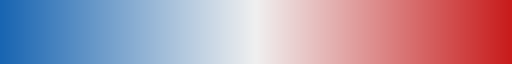

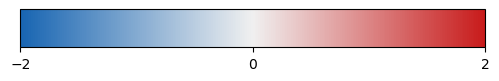

In [38]:
blue = (24, 101, 178)
bad = (240, 240, 240)
red = (200, 27, 27)
colour_scale = ColorScale(blue, bad, red,  'RwB')

# export as svg for figure legend
colour_scale.make_fig(figname=output_dir / "colourmap-rwb.svg")
colour_scale.cm

In [39]:
logfc_cutoffs = (-2, 2)
rc_cuttoffs = (-0.2, 0.2)

In [40]:
colours = [
    # log FCs
    (logfc_min,          colour_scale.neg_hex, colour_scale.neg),   # under
    (logfc_cutoffs[0],   colour_scale.neg_hex, colour_scale.neg),   # min cutoff
    (0,                  colour_scale.zero_hex, colour_scale.zero),  #  0
    (logfc_cutoffs[1],   colour_scale.pos_hex, colour_scale.pos),   # max cutoff
    (neat_logfc_max,     colour_scale.pos_hex, colour_scale.pos),   # over

    # # buffer
    (neat_logfc_max+0.1, "#ffffff",  (255, 255, 255)),   # buffer start
    (phenomics_offset+neat_rc_min-0.1,   "#ffffff", (255, 255, 255)),   # buffer end
    
    # RCs
    (phenomics_offset + neat_rc_min,        colour_scale.neg_hex, colour_scale.neg),   # below
    (phenomics_offset + rc_cuttoffs[0],     colour_scale.neg_hex, colour_scale.neg),   # min cutoff
    (phenomics_offset + 0,                  colour_scale.zero_hex, colour_scale.zero),  #  0
    (phenomics_offset + rc_cuttoffs[1],     colour_scale.pos_hex, colour_scale.pos),   # max cutoff
    (phenomics_offset + rc_max,             colour_scale.pos_hex, colour_scale.pos),   # over
]

In [41]:
# make sure to have the basis network in view in Cytoscape before running this
for day in all_days:
    day = day.split(".")[0]
    
    ###############################################################################################
    style_name = f'{day}.unscaled'

    p4c.styles.copy_visual_style(base_logFC_style, style_name)

    col = f"{day}::{day}.color"
    p4c.style_mappings.set_node_color_mapping(
        col, 
        table_column_values=[x[0] for x in colours], 
        colors=[x[1] for x in colours],
        mapping_type='c', 
        default_color=colour_scale.default_hex, 
        style_name=style_name
    )

    print(f"{style_name} based on {col}")
  
    time.sleep(1)


D08.unscaled based on D08::D08.color
D14.unscaled based on D14::D14.color
D28.unscaled based on D28::D28.color
H01.unscaled based on H01::H01.color
H07.unscaled based on H07::H07.color
H08.unscaled based on H08::H08.color
H14.unscaled based on H14::H14.color
H28.unscaled based on H28::H28.color
HD08.unscaled based on HD08::HD08.color
HD14.unscaled based on HD14::HD14.color
HD28.unscaled based on HD28::HD28.color
W01.unscaled based on W01::W01.color
W07.unscaled based on W07::W07.color
W28.unscaled based on W28::W28.color


In [42]:
# delete columns again (for ease of humans)
for col in p4c.tables.get_table_column_names(table="node", network=biochem_cy):
    try:
        c = col.split("::")[1]
    except: 
        continue
    if c in logFC_columns:
        p4c.tables.delete_table_column(col, table="node", network=biochem_cy)

# Biochem logFC graphs

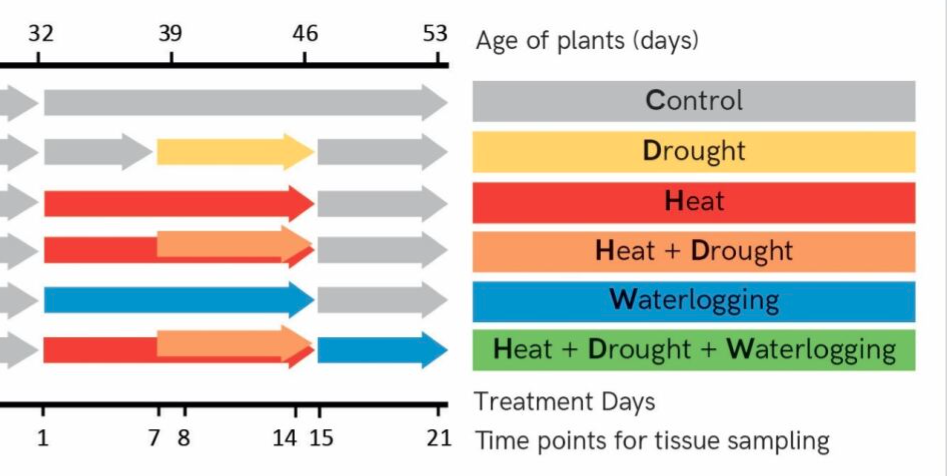


In [43]:
# Days since stress initiation
text_dict = {
    'D08': ('Drought (1 day)', 'Sampling day 8'), #
    'D14': ('Drought (7 days)', 'Sampling day 14'), #
    'D28': ('Drought (21 days)', 'Sampling day 28'),

    'H01': ('Heat (1 day)', 'Sampling day 1'), #
    'H07': ('Heat (7 days)', 'Sampling day 7'), #
    'H08': ('Heat (8 days)', 'Sampling day 8'),
    'H14': ('Heat (14 days)', 'Sampling day 14'),
    'H28': ('Heat (28 days)', 'Sampling day 28'),

    'HD08': ('Heat (8 days) + Drought (1 day)', 'Sampling day 8'), #
    'HD14': ('Heat (14 days) + Drought (7 days)', 'Sampling day 14'), #
    'HD28': ('Heat (28 days) + Drought (21 days)', 'Sampling day 28'),

    'W01': ('Waterlogging (1 day)', 'Sampling day 1'), #
    'W07': ('Waterlogging (7 days)', 'Sampling day 7'), #
    'W28': ('Waterlogging (28 days)', 'Sampling day 28'),
}

In [44]:
biochem_cy_outline = p4c.networks.get_network_suid("basis-with-outline")
biochem_cy_outline

109429

In [45]:
biochem_cy

109032

In [46]:
def clone_network(day, name=None, basis=None):
    if basis is None:
        basis = biochem_cy_outline

    if name is None:
        name = day
        
    cy = p4c.networks.clone_network(network=basis)

    coll_suid = p4c.collections.get_collection_suid(cy)
    try:
        p4c.commands.cyrest_put(base_url=f"http://127.0.0.1:1234/v1/collections/{coll_suid}/tables/default",
                            body={ "key": "SUID", "data": [{ "SUID":coll_suid, "name": name}] })
    except json.JSONDecodeError as e:
        print(e)   
    
    want_cols = [x for x in info_columns + [x for x in logFC_columns if x.startswith(day)] if x in node_df]
    load_table(node_df[want_cols], cy, biochem_graph)

    return cy

In [47]:
all_cys = {}
all_cys_filtered = {}

for day in all_days:
    day = day.split(".")[0]
    
    #############################################
    style_name = f'{day}.unscaled'
    
    subnetwork_name = f'{text_dict[day][0]} - {text_dict[day][1]}'
    
    cy = clone_network(day, name=subnetwork_name)
    
    p4c.styles.set_visual_style(style_name, network=cy)         
    p4c.annotations.add_annotation_text(text=text_dict[day][0], x_pos=-700, y_pos=-470.0, 
                                        font_size=60, font_family="SansSerif", font_style="plain", network=cy)   
    p4c.annotations.add_annotation_text(text=text_dict[day][1], x_pos=-700, y_pos=-400.0, 
                                        font_size=40, font_family="SansSerif", font_style="plain", network=cy)   
    
    all_cys[day] = cy
    p4c.clear_selection()

    #############################################

    time.sleep(1)


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
D08.logFC 76
D08.percent_relative_change 8
D08.color 84


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
D14.logFC 75
D14.percent_relative_change 8
D14.color 83


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
D28.logFC 22
D28.color 22


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
H01.logFC 72
H01.percent_relative_change 8
H01.color 80


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
H07.logFC 74
H07.percent_relative_change 8
H07.color 82


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
H08.logFC 76
H08.percent_relative_change 8
H08.color 84


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
H14.logFC 74
H14.percent_relative_change 8
H14.color 82


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
H28.logFC 22
H28.color 22


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
HD08.logFC 76
HD08.percent_relative_change 8
HD08.color 84


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
HD14.logFC 74
HD14.percent_relative_change 8
HD14.color 82


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
HD28.logFC 22
HD28.color 22


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
W01.logFC 73
W01.percent_relative_change 8
W01.color 81


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
W07.logFC 74
W07.percent_relative_change 8
W07.color 82


In cyrest_put: Expecting value: line 1 column 1 (char 0)


Expecting value: line 1 column 1 (char 0)
display_name 90
group 90
description 90
mapman_bin 32
protein_name 30
short_name 44
pathway 85
W28.logFC 22
W28.color 22


In [48]:
session_file

PosixPath('../output/KnowledgeNetwork.2024-12-10.cys')

In [49]:
p4c.session.save_session(str(session_file.absolute()))

This file has been overwritten.


{}

In [50]:
def export_network(network, filename, format="PDF"):

    # fit content ignores edges that may extend
    # past the node boundaries
    # Reported bug: CSD-979
    p4c.network_views.fit_content(network=network)
    p4c.network_selection.clear_selection(type='both', network=network)

    p4c.network_views.export_image(
        filename=str(filename.absolute()),
        type=format,
        network=network,
        overwrite_file=True,
        # resolution=600
        all_graphics_details=True,
        # hide_labels=False
    )

In [51]:
for day in all_cys:
    cy = all_cys[day]  
    p4c.network_views.fit_content(cy)
    
    filename = fig_dir / f"{day}.{today}.pdf"

    export_network(cy, filename, format="PDF")
    
    print(filename)
    time.sleep(1)

../output/figures/D08.2024-12-10.pdf
../output/figures/D14.2024-12-10.pdf
../output/figures/D28.2024-12-10.pdf
../output/figures/H01.2024-12-10.pdf
../output/figures/H07.2024-12-10.pdf
../output/figures/H08.2024-12-10.pdf
../output/figures/H14.2024-12-10.pdf
../output/figures/H28.2024-12-10.pdf
../output/figures/HD08.2024-12-10.pdf
../output/figures/HD14.2024-12-10.pdf
../output/figures/HD28.2024-12-10.pdf
../output/figures/W01.2024-12-10.pdf
../output/figures/W07.2024-12-10.pdf
../output/figures/W28.2024-12-10.pdf


In [54]:
cy = biochem_cy
p4c.network_views.fit_content(cy)
    
f_name = fig_dir / f"biochem.{today}.pdf"
_ = p4c.network_views.export_image(filename=str(f_name.absolute()), type="PDF", 
                               network=cy, overwrite_file=True,
)

In [55]:
node_df.to_csv(output_dir / f"KnowledgeNetwork_data_merged_table-{today}.tsv", sep="\t")

In [56]:
print("Done")

Done
